In [13]:
import numpy as np
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import great_tables as tg

In [14]:
df = pl.read_csv("../../DATA/mushrooms.csv")

In [15]:
df

class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""p""","""x""","""s""","""n""","""t""","""p""","""f""","""c""","""n""","""k""","""e""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""k""","""s""","""u"""
"""e""","""x""","""s""","""y""","""t""","""a""","""f""","""c""","""b""","""k""","""e""","""c""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""n""","""n""","""g"""
"""e""","""b""","""s""","""w""","""t""","""l""","""f""","""c""","""b""","""n""","""e""","""c""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""n""","""n""","""m"""
"""p""","""x""","""y""","""w""","""t""","""p""","""f""","""c""","""n""","""n""","""e""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""p""","""k""","""s""","""u"""
"""e""","""x""","""s""","""g""","""f""","""n""","""f""","""w""","""b""","""k""","""t""","""e""","""s""","""s""","""w""","""w""","""p""","""w""","""o""","""e""","""n""","""a""","""g"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""e""","""k""","""s""","""n""","""f""","""n""","""a""","""c""","""b""","""y""","""e""","""?""","""s""","""s""","""o""","""o""","""p""","""o""","""o""","""p""","""b""","""c""","""l"""
"""e""","""x""","""s""","""n""","""f""","""n""","""a""","""c""","""b""","""y""","""e""","""?""","""s""","""s""","""o""","""o""","""p""","""n""","""o""","""p""","""b""","""v""","""l"""
"""e""","""f""","""s""","""n""","""f""","""n""","""a""","""c""","""b""","""n""","""e""","""?""","""s""","""s""","""o""","""o""","""p""","""o""","""o""","""p""","""b""","""c""","""l"""


In [6]:
X = df.select(cs.exclude('class'))

In [5]:
y = df.select('class').to_series()

In [22]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [21]:
ordinal_encoder = OrdinalEncoder()

In [23]:
X_encoded = ordinal_encoder.fit_transform(X)

In [25]:
X_encoded = pl.DataFrame(X_encoded, schema=X.schema)

In [9]:
label_encoder = LabelEncoder()

In [11]:
y_encoded = label_encoder.fit_transform(y)

In [29]:
y_encoded = pl.Series('class', y_encoded)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.15, random_state=42)

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
gradient_boosting_classifier = GradientBoostingClassifier()

In [45]:
param_grid = {
    'n_estimators': [1, 5, 10, 20, 40, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    # 'min_samples_split': [2, 5, 10, 20, 50, 100],
    # 'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100]
}

In [46]:
grid_model = GridSearchCV(
    estimator=gradient_boosting_classifier,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,

)

In [47]:
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [1, 5, 10, 20, 40, 100]},
             verbose=1)

In [48]:
grid_model.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5}

In [49]:
grid_model.best_score_

np.float64(1.0)

In [50]:
grid_model.score(X_test, y_test)

1.0

In [52]:
predictions = grid_model.predict(X_test)

In [56]:
pl.DataFrame({
    'actual': y_test,
    'actual_decoded': label_encoder.inverse_transform(y_test),
    'predicted': predictions,
    'predicted_decoded': label_encoder.inverse_transform(predictions),
    'correct': pl.Series(predictions) == pl.Series(y_test),
})

actual,actual_decoded,predicted,predicted_decoded,correct
i64,str,i64,str,bool
0,"""e""",0,"""e""",true
1,"""p""",1,"""p""",true
1,"""p""",1,"""p""",true
0,"""e""",0,"""e""",true
1,"""p""",1,"""p""",true
…,…,…,…,…
1,"""p""",1,"""p""",true
1,"""p""",1,"""p""",true
0,"""e""",0,"""e""",true


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [60]:
confusion_matrix(y_test, predictions)

array([[637,   0],
       [  0, 582]])

In [73]:
print(classification_report(
    y_test, predictions,
    target_names=label_encoder.classes_,
    zero_division=0,
))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       637
           p       1.00      1.00      1.00       582

    accuracy                           1.00      1219
   macro avg       1.00      1.00      1.00      1219
weighted avg       1.00      1.00      1.00      1219



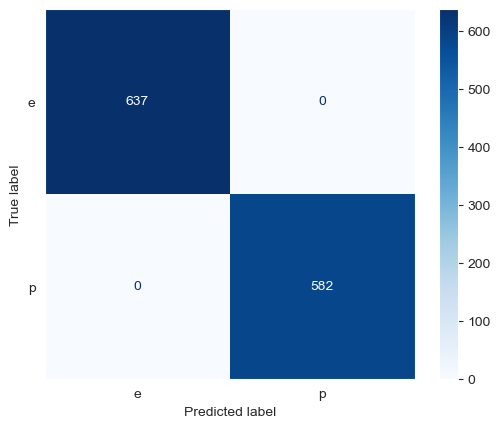

In [78]:
ConfusionMatrixDisplay.from_predictions(
    y_test, predictions,
    cmap='Blues',
    display_labels=label_encoder.classes_,
).ax_.grid(False)

In [84]:
feat_import = grid_model.best_estimator_.feature_importances_
feature_names = X.columns

In [90]:
feat_import = pl.DataFrame({
    'Feature': feature_names,
    'Importance': feat_import,
}).filter(
    pl.col('Importance') > 0.000527
).sort('Importance', descending=False)

In [99]:
feat_import.plot.bar(x='Feature', y='Importance')

alt.Chart(...)

<Figure size 1200x600 with 0 Axes>

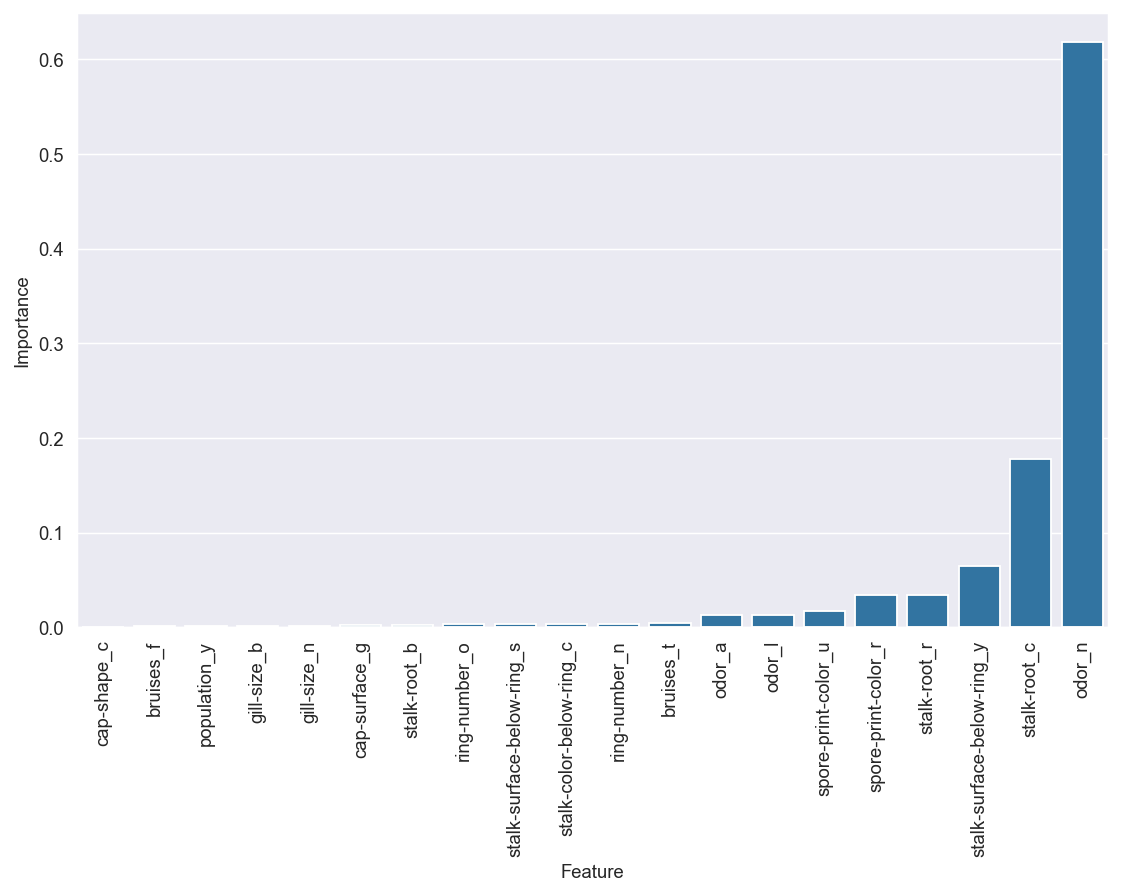

In [94]:
plt.figure(figsize=(10, 6), dpi=133)
sns.barplot(data=feat_import, x='Feature', y='Importance')
plt.xticks(rotation=90);